# Movie Dataset Data inspection and preprocessing

In [31]:
import numpy as np
import pandas as pd

# Read in the data
# Because the ultimate goal of our project is to build a system which predict the revenue of non-released movies, 
# we propose that the revenue is likely to be related to the case, genere, production company, and the release date of the movie.
# In the rest of this notebook, we will try to verify our hypothesis by inspecting the data.
metadata_path = 'data/movies_metadata.csv'
credit_path = 'data/credits.csv'

import warnings
# warnings.filterwarnings('ignore')

metadata = pd.read_csv(metadata_path, low_memory=False)
credit = pd.read_csv(credit_path, low_memory=False)

Since we are building a system that predict the revenue of un-released movies, the user ratings, votes, we will not have them.  
We will drop those columns.

In [32]:
id_to_drop = []
for i in range(45465+1):
    try:
        int_id = int(metadata['id'][i])
    except:
        print(i, metadata['id'][i], metadata['title'][i])
        id_to_drop.append(i)  
for i in reversed(id_to_drop):    
    metadata.drop(i, axis=0, inplace=True)

19730 1997-08-20 nan
29503 2012-09-29 nan
35587 2014-01-01 nan


In [33]:
# Because the id in metadata is string, we need to convert it to int so that we can merge the two dataframes.
metadata['id'] = metadata['id'].astype(int)
full_data = pd.merge(metadata, credit, left_on='id', right_on='id', how='left')

We can see that there are some nans in some of the columns, some columns has small numbers of nans which could be ignored. Some column like belongs_to_collection, nan means no collection that the movie is belong to, so we need to create special embedding for that. Another way of doing is some data might be nan in our csv but available online, we can find them and fill in it ourselves.

Here because there are hundreds of data missing in column release data and runtime, we just remove them.

In [34]:
# Remove nans in release_date and runtime
full_data.drop(full_data[full_data['release_date'].isnull()].index, inplace=True)
full_data.drop(full_data[full_data['runtime'].isnull()].index, inplace=True)

We have the release data in string format, we will only keep month for future use.

In [35]:
full_data['release_date'] = pd.to_datetime(full_data['release_date'], format='%Y-%m-%d',errors='coerce').dt.month.astype(int)

Upon inspecting, we can see that some of the columns are json in string format. We could convert them from string to dictionary, so we save a lot of work reading useful data.

In [36]:
import json
import math
from json.decoder import JSONDecodeError

json_columns = ['belongs_to_collection', 'genres', 'spoken_languages', 'production_companies', 'production_countries', 'cast', 'crew']
# We defined those columns as json columns because they are in json format.
def correction_and_load_json(json_str):
    if isinstance(json_str, float) and math.isnan(json_str):
        return json_str
    if isinstance(json_str, dict):
        return json_str
    if json_str is None:
        return json_str
    try:
        return json.loads(json_str)
    except JSONDecodeError:
        fixed_str = json_str.replace("'", '"')
        try:
            return json.loads(fixed_str)
        except:
            # print(json_str)
            return json_str

        # try:
        #     return json.loads(fixed_str)
        # except:
        #     # If you can't fix it, return a NaN
        #     return np.nan
    except TypeError:
        # print(json_str)
        return json_str
    except:
        print(json_str)
        # return np.nan
        return json_str

for column in json_columns:
    # print("Current column: ", column)
    full_data[column] = full_data[column].map(correction_and_load_json)

In [37]:
has_or_not = ['belongs_to_collection', 'homepage', 'tagline']
new_column = ['has_collection', 'has_homepage', 'has_tagline']
for i in range(len(has_or_not)):
    full_data[new_column[i]] = full_data[has_or_not[i]].apply(lambda x: 0 if x is np.nan else 1)

In [38]:
# Add crew_count feature
full_data['crew_count'] = full_data['crew'].apply(lambda x: len(x) if x is not np.nan else 0)
# Add genres_count feature
full_data['genres_count'] = full_data['genres'].apply(lambda x: len(x) if x is not np.nan else 0)

In [40]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(full_data.head(5))

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,has_collection,has_homepage,has_tagline,crew_count,genres_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",10,3.736e+08,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",1,1,0,18654,3
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",12,2.628e+08,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",0,0,1,2861,3
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",12,0.000e+00,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",1,0,1,748,2
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",12,8.145e+07,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",0,0,1,1736,3
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",2,7.658e+07,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",1,0,1,1269,1


In [41]:
full_data

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,cast,crew,has_collection,has_homepage,has_tagline,crew_count,genres_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",1,1,0,18654,3
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",0,0,1,2861,3
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",1,0,1,748,2
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",0,0,1,1736,3
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",1,0,1,1269,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45533,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,30840,tt0102797,en,Robin Hood,"Yet another version of the classic epic, with ...",...,False,5.7,26.0,"[{'cast_id': 1, 'character': 'Sir Robert Hode'...","[{'credit_id': '52fe44439251416c9100a899', 'de...",0,0,0,1474,3
45535,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,False,9.0,3.0,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",0,0,0,1096,1
45536,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,False,3.8,6.0,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",0,0,1,878,3
45537,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,False,0.0,0.0,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",0,0,0,368,0


## Remove movie that have 0 revenue from our dataset

In [9]:
# full_data = full_data[full_data['revenue'] != 0]

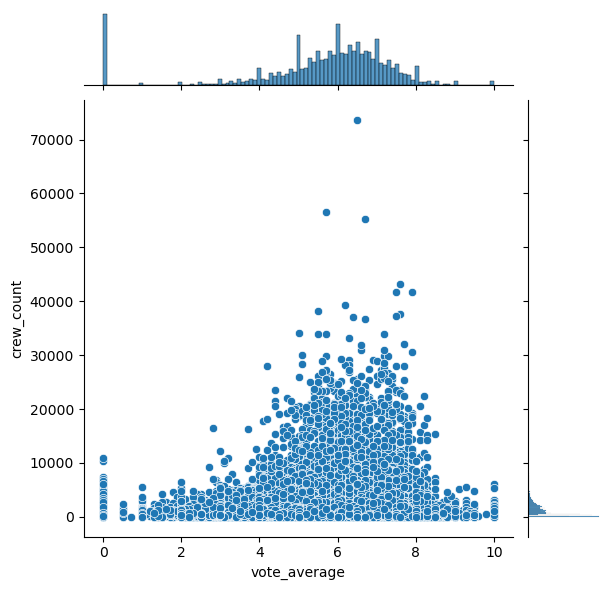

In [43]:
import seaborn as sns

# plot crew_count vs revenue
sns.jointplot(x='vote_average', y='crew_count', data=full_data)


In [44]:
full_data['genres_top'] = full_data['genres'].apply(lambda x: x[0]['name'] if x is not np.nan and len(x)>0 else np.nan)
full_data['genres_second'] = full_data['genres'].apply(lambda x: x[1]['name'] if x is not np.nan and len(x)>1 else np.nan)

In [45]:
full_data["has_collection"] = full_data["belongs_to_collection"].apply(lambda x: 0 if x is np.nan else 1)

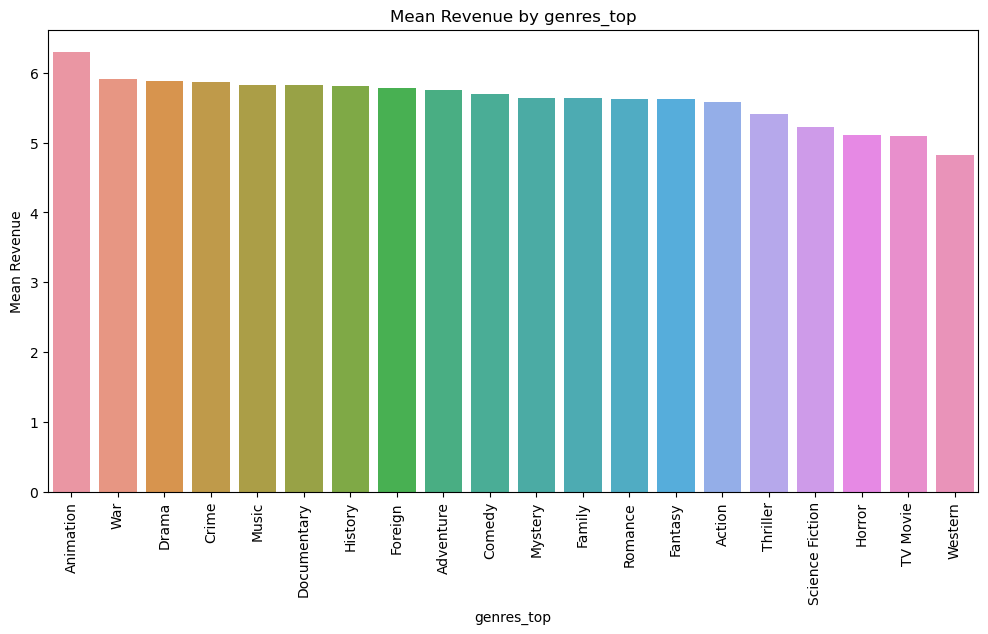

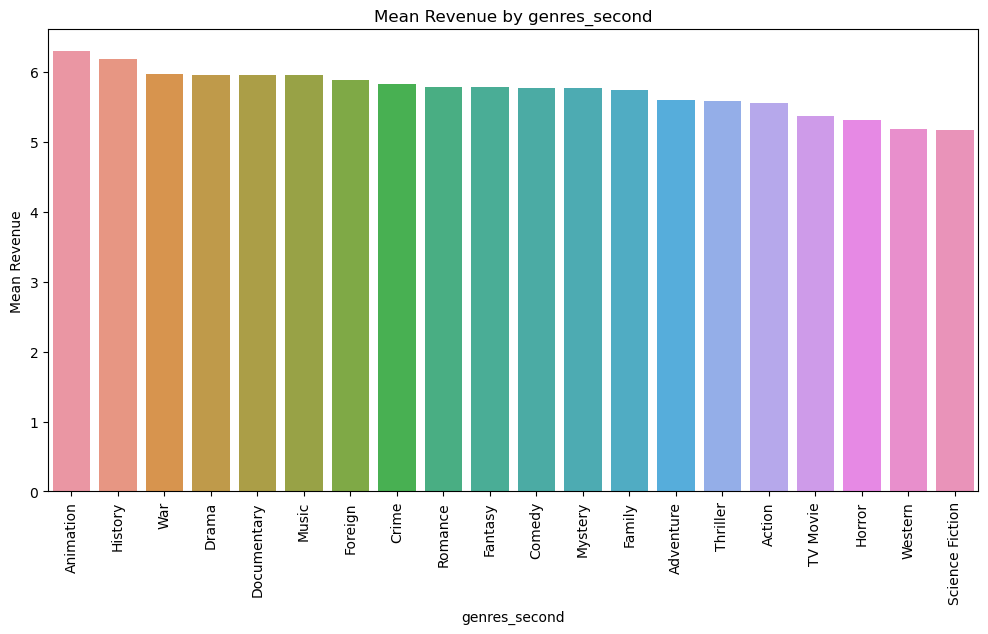

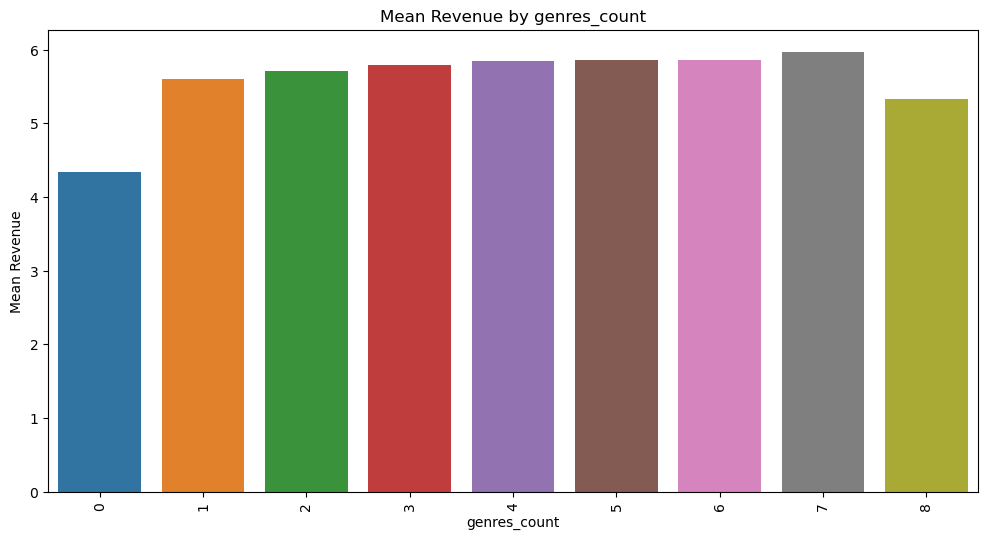

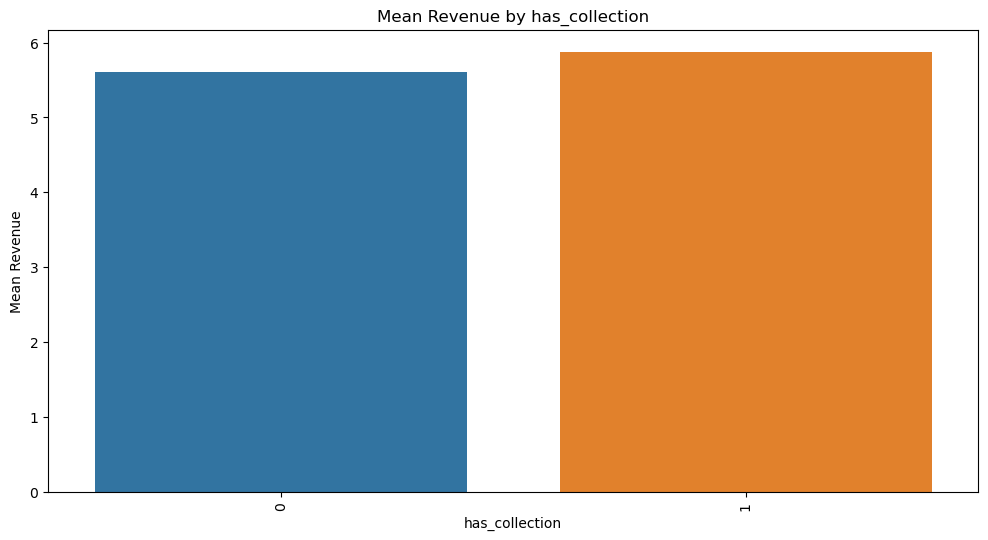

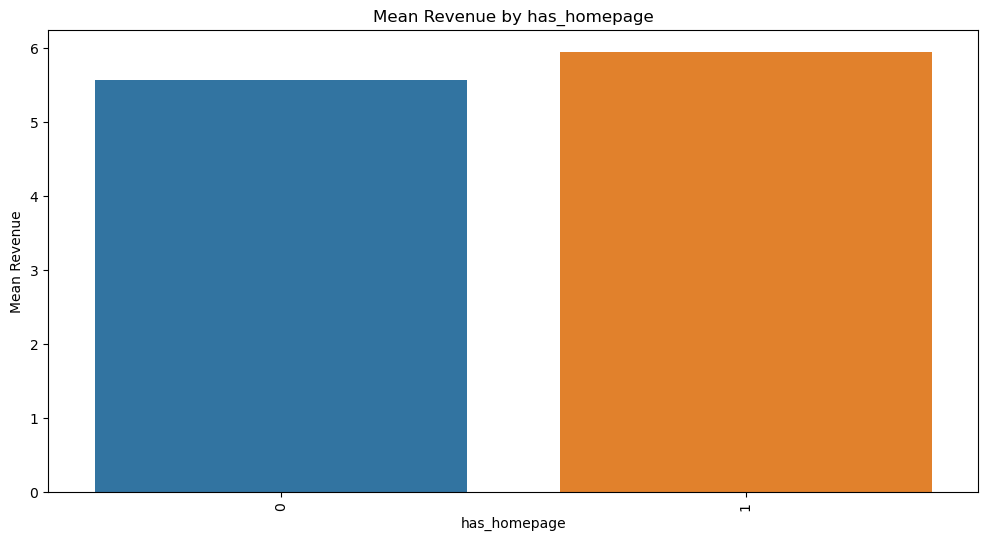

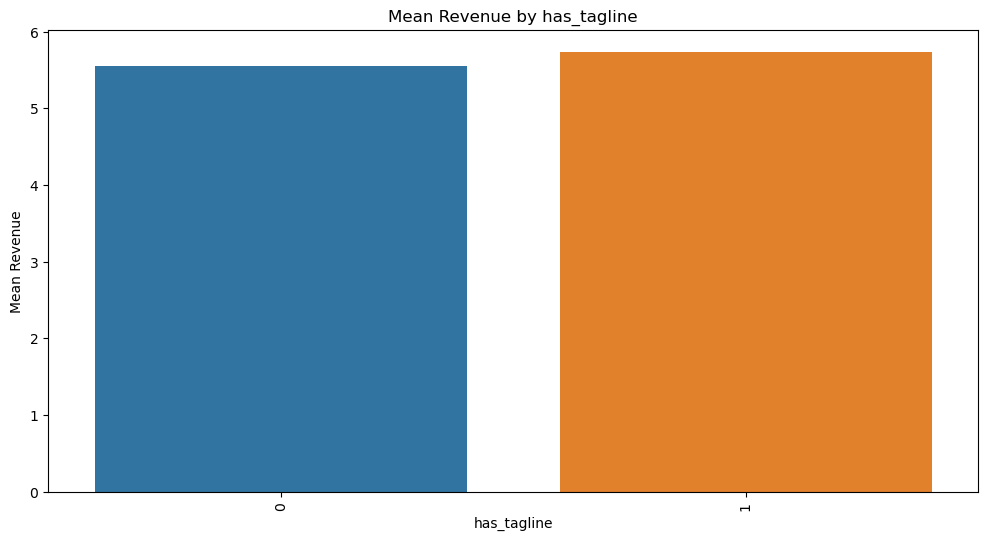

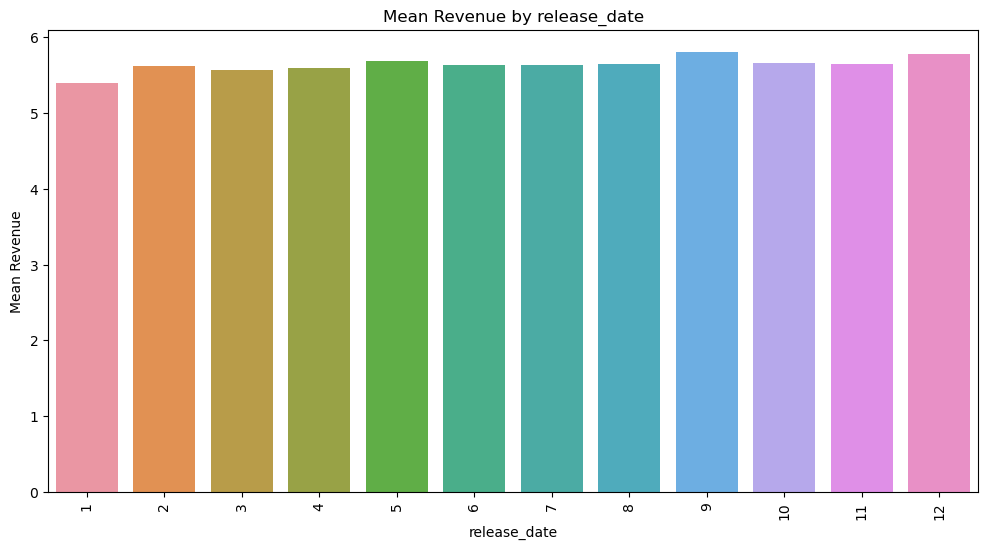

In [46]:
import matplotlib.pyplot as plt

categorical_columns = ['genres_top','genres_second', 'genres_count', 'has_collection', 'has_homepage', 'has_tagline','release_date']
numerical_column = 'vote_average'


for cat_col in categorical_columns:
    mean_revenue_df = full_data.groupby(cat_col, as_index=False)[numerical_column].mean()
    mean_revenue_df = mean_revenue_df.sort_values(by=numerical_column, ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=cat_col, y=numerical_column, data=mean_revenue_df)
    
    
    plt.title(f"Mean Revenue by {cat_col}")
    plt.xlabel(cat_col)
    plt.ylabel("Mean Revenue")
    
    
    plt.xticks(rotation=90)
    plt.show()

In [50]:
column_to_convert = ['genres_top','genres_second', 'genres_count', 'has_collection', 'has_homepage', 'has_tagline','release_date']
selected_data = full_data[column_to_convert]
for column_name in column_to_convert:
    color_dummies = pd.get_dummies(selected_data[column_name], prefix=column_name)
    # test_color_dummies = pd.get_dummies(selected_data[column_name], prefix=column_name)
    # Concatenate the original DataFrame with the new one-hot encoded columns
    selected_data = pd.concat([selected_data.drop(column_name, axis=1), color_dummies], axis=1)
    # selected_data = pd.concat([selected_data.drop(column_name, axis=1), test_color_dummies], axis=1)

from sklearn.preprocessing import StandardScaler

label_column = 'vote_average'

selected_data = pd.concat([selected_data, full_data[label_column]], axis=1)
selected_data = pd.concat([selected_data, full_data['budget']], axis=1)
selected_data = pd.concat([selected_data, full_data['crew_count']], axis=1)

scaler = StandardScaler()
scaler.fit(selected_data[['crew_count']])
scaler.transform(selected_data[['crew_count']])

train_data = selected_data.drop([label_column], axis=1).to_numpy().astype(np.float32)
train_label = selected_data[label_column].to_numpy().astype(np.float32)
# test_data = selected_data.drop([label_column], axis=1).to_numpy().astype(np.float32)
# test_label = selected_data[label_column].to_numpy().astype(np.float32)
train_data.shape, train_label.shape

((45206, 69), (45206,))

## Do a regression MLP

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define a custom dataset class
class myDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

train_data_torch = torch.from_numpy(train_data)
test_data_torch = torch.from_numpy(test_data)
n_class = 2
# train_label_one_hot = np.eye(n_class)[train_label.astype(int)]
# test_label_one_hot = np.eye(n_class)[test_label.astype(int)]
train_label = train_label.reshape(-1, 1)
test_label = test_label.reshape(-1, 1)
train_label_torch = torch.from_numpy(train_label.astype(np.float32))
test_label_torch = torch.from_numpy(test_label.astype(np.float32))
train_dataset = myDataset(train_data_torch, train_label_torch)
test_dataset = myDataset(test_data_torch, test_label_torch)

N, D = train_data_torch.shape
N, D

(45206, 69)

In [58]:
trainset, valset = torch.utils.data.random_split(train_dataset, [40000, N-40000])
print(f'Train set size: {len(trainset)}, Validation set size: {len(valset)}')

Train set size: 40000, Validation set size: 5206


In [59]:
# Define function to call for each training epoch (one complete pass over the training set)
def train(model, trainloader, criterion, optimizer, device):
    model.train() # set model to training mode
    running_loss = 0; running_acc = 0
    with tqdm(total=len(trainloader), desc=f"Train", unit="batch") as pbar:
        for n_batch, (train_data, labels) in enumerate(trainloader): # Iterate over batches
            train_data, labels = train_data.to(device), labels.to(device) # Move batch to device
            optimizer.zero_grad()
            output = model(train_data) # Forward pass
            loss = criterion(output, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            # running_loss += loss.item()
            # running_acc += (output.argmax(1) == labels.argmax(1)).float().mean().item()
            pbar.set_postfix({'loss': loss.item()})# , 'acc': 100. * running_acc / (n_batch+1)})
            pbar.update() # Update progress bar
    return running_loss / len(trainloader)#, running_acc / len(trainloader) # return loss and accuracy for this epoch

In [60]:
# Define function to call for each validation epoch (one complete pass over the validation set)
def validate(model, valloader, criterion, device):
    model.eval() # set model to evaluation mode (e.g. turn off dropout, batchnorm, etc.)
    running_loss = 0; running_acc = 0
    with torch.no_grad(): # no need to compute gradients for validation
        with tqdm(total=len(valloader), desc=f"Eval", unit="batch") as pbar:
            for n_batch, (train_data, labels) in enumerate(valloader): # Iterate over batches
                train_data, labels = train_data.to(device), labels.to(device) # Move batch to device
                output = model(train_data) # Forward pass
                loss = criterion(output, labels) # Compute loss
                running_loss += loss.item()
                #running_acc += (output.argmax(1) == labels.argmax(1)).float().mean().item()
                pbar.set_postfix({'loss': loss.item()})#, 'acc': 100. * running_acc / (n_batch+1)})
                pbar.update() # Update progress bar
    return running_loss / len(valloader)#, running_acc / len(valloader)  # return loss and accuracy for this epoch

In [61]:
# set the device to use and move model to device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.torch.backends.mps.is_available():
    device = torch.device("mps") # MPS acceleration is available on MacOS 12.3+
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


In [66]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)
    
class MLP(nn.Module):
    def __init__(self, n_feature, n_classes, n_hidden): # Define layers in the constructor
        super().__init__()
        self.fc1 = nn.Linear(n_feature, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x): # Define forward pass in the forward method
        x = x.view(x.shape[0], -1)  #flatten into a 784 length tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x # note: no softmax, as this is included in the loss function in PyTorch


In [68]:
batchsize = 50
n_feature = D
output_class = 1
n_hidden = 48
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

model = MLP(n_feature, output_class, n_hidden).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

n_epoch = 40
best_acc = -1
train_loss_history = []; train_acc_history = []
val_loss_history = []; val_acc_history = []
for epoch in range(n_epoch):
    print(f"Epoch {epoch+1}/{n_epoch}")
    train_loss = train(model, trainloader, criterion, optimizer, device)
    val_loss    = validate(model, valloader, criterion, device)

    train_loss_history.append(train_loss)#; train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)#; val_acc_history.append(val_acc)

Epoch 1/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 392.02batch/s, loss=0.785]  


Epoch 2/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 508.80batch/s, loss=0.843]  


Epoch 3/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 531.01batch/s, loss=11.7]  


Epoch 4/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 522.47batch/s, loss=0.747]  


Epoch 5/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 542.97batch/s, loss=0.854]


Epoch 6/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 518.60batch/s, loss=0.645]  


Epoch 7/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 525.23batch/s, loss=0.803]


Epoch 8/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 524.85batch/s, loss=2.07]   


Epoch 9/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 524.57batch/s, loss=0.626]


Epoch 10/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 510.97batch/s, loss=0.843]


Epoch 11/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 524.81batch/s, loss=0.713]


Epoch 12/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 525.55batch/s, loss=0.808]


Epoch 13/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 523.36batch/s, loss=0.695]  


Epoch 14/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 518.85batch/s, loss=1.41]


Epoch 15/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 508.62batch/s, loss=0.682]


Epoch 16/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 512.64batch/s, loss=0.653]  


Epoch 17/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 527.61batch/s, loss=0.978]


Epoch 18/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 521.47batch/s, loss=0.956]


Epoch 19/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 533.57batch/s, loss=3.1] 


Epoch 20/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 535.20batch/s, loss=1.12]


Epoch 21/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 539.11batch/s, loss=1.07]


Epoch 22/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 512.98batch/s, loss=0.677]


Epoch 23/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 449.91batch/s, loss=5.07]


Epoch 24/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 508.84batch/s, loss=1.2] 


Epoch 25/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 514.37batch/s, loss=0.86]


Epoch 26/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 523.86batch/s, loss=1.27]


Epoch 27/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 523.33batch/s, loss=1]   


Epoch 28/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 520.77batch/s, loss=0.693]


Epoch 29/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 514.47batch/s, loss=0.76]


Epoch 30/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 511.71batch/s, loss=0.617]


Epoch 31/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 527.00batch/s, loss=0.86]


Epoch 32/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 504.43batch/s, loss=0.744]


Epoch 33/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 525.97batch/s, loss=0.656]


Epoch 34/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 500.96batch/s, loss=0.571]


Epoch 35/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 513.78batch/s, loss=0.951]


Epoch 36/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 526.46batch/s, loss=0.673]


Epoch 37/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 516.26batch/s, loss=0.554]


Epoch 38/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 518.71batch/s, loss=0.675]


Epoch 39/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 517.78batch/s, loss=0.679]


Epoch 40/40


Eval: 100%|██████████| 105/105 [00:00<00:00, 508.19batch/s, loss=0.806]


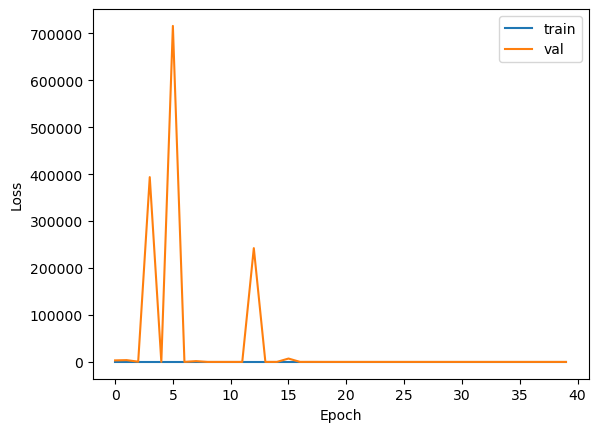

In [71]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()